# Comparing models

## Introduction

In biostatistics, we often encounter data that suggests relationships between variables. But how do we determine if these relationships are real and meaningful, or just due to chance? This is where the crucial concept of **model comparison** comes in. It allows us to systematically evaluate different explanations for our data and choose the one that best fits the evidence.

In this chapter, we'll focus on using **linear regression** as a powerful tool for understanding model comparison. We'll start with the simplest possible model—a horizontal line representing the mean of our data—and then explore how adding variables improves our ability to explain and predict outcomes. By comparing these models, we gain valuable insights into the relationships within our data.

We'll delve into the **ANOVA table**, which helps us assess the improvement in fit offered by a more complex model. We'll also discover how a familiar technique, the *unpaired t-test*, can be viewed as a special case of model comparison within the linear regression framework.

Throughout the chapter, we'll emphasize the connection between model comparison and P values, highlighting how these values help us make informed decisions about the strength of evidence for different hypotheses. We'll also take a look forward to the **F-test** for unrelated models and discuss P-values in the context of model comparison and model selection.

## Comparing regression models to the mean

### The horizontal line model

We can use P values and R² from a **linear regression**, but let's shift our focus to *comparing two models*: the linear regression model and the null hypothesis model. What is this null hypothesis model? It's the **simplest model** we can imagine: a *horizontal line at the mean of all the y-values*.

Imagine plotting the data points on a graph. The horizontal line model essentially says, "let's just use the average y value to predict every single outcome, regardless of the X values."  It's like saying there's *no relationship* between X and y.

This simple model serves as a baseline for comparison. When we fit a linear regression model, we're trying to do *better* than simply predicting the mean. We're attempting to capture a trend in the data that allows us to make more accurate predictions.

We'll continue our analysis of the relationship between insulin sensitivity and C20-22 fatty acids, using the same dataset from the previous chapters on correlation and simple linear regression.

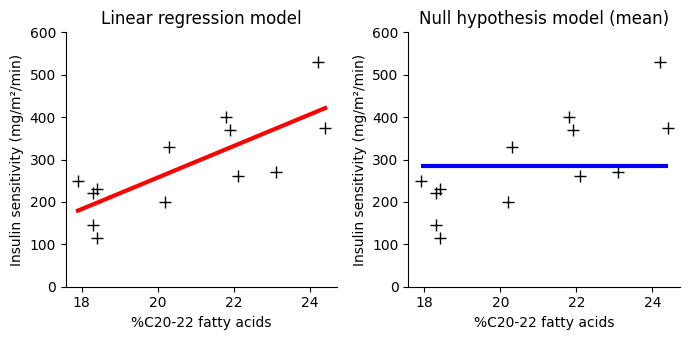

In [271]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns  # For better aesthetics

# Example data from last chapters (directly into a DataFrame)
data = pd.DataFrame({
    'per_C2022_fatacids': [17.9, 18.3, 18.3, 18.4, 18.4, 20.2, 20.3, 21.8, 21.9, 22.1, 23.1, 24.2, 24.4],
    'insulin_sensitivity': [250, 220, 145, 115, 230, 200, 330, 400, 370, 260, 270, 530, 375],
})

# --- Perform the linear regression ---
X = data['per_C2022_fatacids']  # More descriptive variable names
y = data['insulin_sensitivity']

slope, intercept = np.polyfit(X, y, deg=1)

# --- Create the plots ---
plt.figure(figsize=(7, 3.5))  # Slightly wider figure for better spacing

# --- Subplot 1: Linear Regression Model ---
plt.subplot(1, 2, 1)
plt.plot(X, y, 'k+', ms=8)
plt.ylim(0, 600)

y_line = slope * X + intercept
plt.plot(X, y_line, 'r-', lw=3)  # Plot the regression line

plt.xlabel('%C20-22 fatty acids')
plt.ylabel('Insulin sensitivity (mg/m²/min)')
plt.title('Linear regression model')

# --- Subplot 2: Null Hypothesis Model (Horizontal Line) ---
plt.subplot(1, 2, 2)
plt.plot(X, y, 'k+', ms=8)
plt.ylim(0, 600)

y_mean = y.mean()  # Calculate the mean of Y
plt.hlines(
    y=y_mean, xmin=X.min(), xmax=X.max(),
    colors='b', linestyles='-', lw=3)  # Draw an horizontal line

plt.xlabel('%C20-22 fatty acids')
plt.ylabel('Insulin sensitivity (mg/m²/min)')
plt.title('Null hypothesis model (mean)')
plt.tight_layout()
sns.despine();

By comparing the linear regression model to the horizontal line model, we can answer crucial questions:

- Does our regression model actually improve our ability to predict y?
- Is the relationship between X and y strong enough to be considered statistically significant?

To answer these questions, we'll delve into the concepts of R², sums of squares, and the **ANOVA table**, all within the context of comparing these two models. This approach will give us a deeper understanding of how linear regression works and how we can use it to draw meaningful conclusions from our data.

### R-squared

In the previous chapter, we delved into the details of R-squared (R²) as a measure of how well a linear regression model fits our data. Now, let's revisit R² from the perspective of model comparison.

Remember that R² tells us the proportion of variance in the outcome variable (y) that is explained by our predictor variable (X). But what does this really mean? Now think of it this way; the horizontal line model (null hypothesis) simply uses the mean of Y to predict all values. The variability of the data points around this horizontal line represents the **total variability** in y. On the other side, the linear regression model tries to capture a trend in the data. If the regression line fits the data well, the variability of the points around this line will be *less* than the variability around the horizontal line.

Essentially, the linear regression model "explains away" some of the variability in the data by accounting for the relationship between X and y. R² quantifies how much of that total variability is explained by the regression model.

To put it mathematically, recall the formula for R²:

$$R^2 = \frac{\text{TSS} - \text{RSS}}{\text{TSS}} = 1 - \frac{\text{RSS}}{\text{TSS}}$$

where the **total sum of squares (TSS)** represents the total variability in $y$ around the horizontal line (the mean $\bar y$), and the **residual sum of squares (RSS)** represents the remaining variability in $y$ around the regression line after accounting for the effect of $X$:

$$
\text{TSS} = \sum{(y_i - \bar{y})^2}
\qquad
\text{RSS} = \sum{(y_i - \hat{y}_i)^2}
$$

R² is the proportion of the total variability (TSS) that is reduced by using the regression model instead of just the mean. A higher R² indicates a better fit, meaning the regression model explains more of the variation in the data compared to the simple horizontal line model.

### Sums of squares and variation

We've been using the terms TSS, RSS, and TSS-RSS to represent the different components of variation. However, we might also encounter the terms **SST**, **SSE**, and **SSR**, which stand for *sum of squares total*, *sum of squares error* (errors are residuals), and *sum of squares regression*, respectively. These terms are equivalent to the ones we've been using and represent the same underlying concepts. So we can also write:

$$R^2 = \frac{\text{SSR}}{\text{SST}} = 1 - \frac{\text{SSE}}{\text{SST}}$$

**Important Note:** In Statsmodels, the `ssr` attribute of a regression results object refers to the [sum of squared *residuals* (SSE)](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLSResults.ssr.html), not the sum of squares due to *regression* (SSR). This is different from the conventional use of the abbreviation "SSR".

In [272]:
# Define functions to compute RSS and estimate y
def compute_sse(y_estimate, y):
  return sum(np.power(y - y_estimate, 2))

def estimate_y(X, intercept, slope):
  return intercept + slope * X

# Calculate RSS and TSS
sse = compute_sse(estimate_y(X=X, intercept=intercept, slope=slope), y)  # RSS
sst = compute_sse(np.mean(y), y)  # SST
# sst = (y  - y.mean()).pow(2).sum()  # SST
ssr = sst - sse  # TSS - RSS

# Print RSS, TSS and R²
print(f"Scatter around the regression line (RSS or SSE): {sse:.1f}")
print(f"Scatter around the horizontal line (TSS or SST): {sst:.1f}")
print(f"Variability explained by the regression model (SSR): {ssr:.1f}")
print(f"R²: {1 - sse/sst:.4f}")
print(f"Proportion of variation explained by the regression line (SSR/SST)= {ssr/sst:3.1%}")
print(f"Scatter around the regression line (SSE/SST) accounts for {1 - (ssr/sst):3.1%} of the total variation")

Scatter around the regression line (RSS or SSE): 63361.4
Scatter around the horizontal line (TSS or SST): 155642.3
Variability explained by the regression model (SSR): 92280.9
R²: 0.5929
Proportion of variation explained by the regression line (SSR/SST)= 59.3%
Scatter around the regression line (SSE/SST) accounts for 40.7% of the total variation


### Analysis of variance

#### Sources of variation

To formally compare the null hypothesis model (horizontal line) with the linear regression model, we need a way to systematically assess how much the regression model improves our ability to explain the variation in the data. This is where the concept of **analysis of variance (ANOVA)** becomes essential.

Before we introduce the structured framework that ANOVA provides, let's first break down the key sources of variation and their associated sums of squares:

| Hypothesis  | Scatter from    | Variation         | Sum of squares | Variation | R²    |
|:----------- |:--------------- |:----------------- |:--------------:|:--------- |:----- |
| Null        | Horizontal line | Total (SST)       |     155642     |  100.0%   |       |
| Alternative | Regression line | Unexplained (SSE) |      63361     |  40.7%    |       |
| Difference  | Improvement     | Explained (SSR)   |      92281     |  59.3%    | 0.593 |

This table highlights the following:

- **Total variation (SST)**: the 'null hypothesis' row represents the total variability in the data around the mean, captured by the sum of squares of 155642. This is our baseline.
- **Unexplained or *random* variation (SSE)**: the 'alternative hypothesis' row shows the variability that remains unexplained after fitting the regression line (63361).
- **Explained variation (SSR)**: the 'difference' row shows how much variability is explained by the regression model (92281). This is the improvement we gain by using the regression line instead of just the mean.
- R-squared: as we've seen, R² (0.593) is the proportion of the total variation explained by the regression model. It's the ratio of the explained variation (SSR) to the total variation (SST).

#### Visualizing the residuals

To better understand the difference in scatter between the two models, let's visualize the residuals.  Recall that a residual is the vertical distance between an observed data point and the model's prediction.

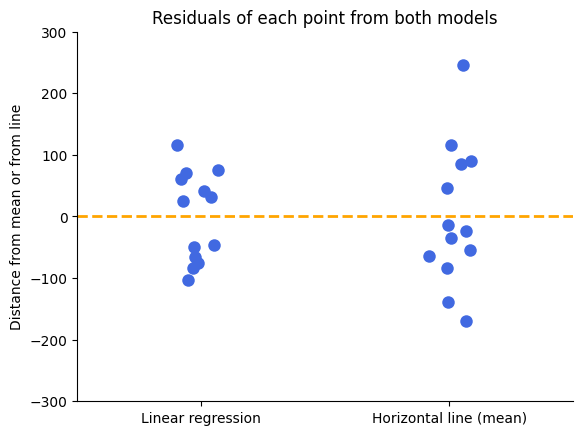

In [273]:
# Residuals from linear regression
resid_lin = (y - estimate_y(X, intercept, slope)).to_numpy()

# Residuals from horizontal line (mean)
resid_mean = (y - y.mean()).to_numpy()

sns.stripplot(data=[resid_lin, resid_mean], color='royalblue', size=9)
plt.axhline(
    y=0,
    color='orange',
    linestyle='--',
    linewidth=2)
plt.ylabel("Distance from mean or from line")
plt.ylim((-300, 300))
plt.xticks([0, 1], ['Linear regression', 'Horizontal line (mean)'])
plt.title("Residuals of each point from both models")
sns.despine();

The spread of the residuals is visibly smaller around the linear regression line compared to the horizontal line, indicating a better fit for the linear regression model.

#### Degrees of freedom

Each source of variation in the ANOVA table has an associated number of **degrees of freedom (DF)**. Degrees of freedom represent the number of independent pieces of information available to estimate a parameter:

- Regression: this is equal to the number of predictor variables ($p$) in the model. In simple linear regression, we have *only one predictor* $X$, so $\text{DF}_\text{regression} = p = 1$.
- Error (residual, or random): this is calculated as the total number of observations ($n$) minus the number of predictor variables ($p$) in the model, minus 1. In simple linear regression, we have one predictor variable, so  $\text{DF}_\text{error} = n - p - 1 = n - 1 - 1 = n - 2$.
- Total (the null hypothesis, horizontal line, or mean): this is equal to the total number of observations minus 1 (because we know the mean), which is $\text{DF}_\text{total} = n - 1$.

Essentially, the total degrees of freedom ($n - 1$) are partitioned between the regression model (1) and the remaining error ($n - 2$):

$$\text{DF}_\text{total} =  \text{DF}_\text{error} + \text{DF}_\text{regression}$$

This reflects that the linear model has one more parameter (the slope) than the null hypothesis model (which only estimates the mean).

Degrees of freedom are crucial because they affect the calculation of the mean squares and the F-statistic in the ANOVA table. They essentially adjust for the number of parameters being estimated, ensuring that our statistical tests are accurate.

#### Mean squares

In the ANOVA table, we don't just use the sums of squares (SST, SSR, SSE) directly. We also calculate **mean squares (MS)**, also called _estimates of variance_, which are essentially "averaged" sums of squares. They represent the average variation attributed to each source, adjusted for their degrees of freedom.

Here's how we calculate the mean squares:

- **MSR (mean square regression)**: SSR (sum of squares regression) divided by its degrees of freedom ($\text{DF} = 1$ in simple linear regression):
  
  $$\text{MSR} = \frac{\text{SSR}}{\text{DF}_\text{regression}} = \text{SST} - \text{SSE}$$
  
- **MSE (mean square error)**: SSE (sum of squares error) divided by its degrees of freedom ($\text{DF} = n - 2$ in simple linear regression):
  
  $$\text{MSE} = \frac{\text{SSE}}{n - p - 1} = \frac{\text{SSE}}{n - 2}$$

Mean squares allow us to compare the different sources of variation on a more even playing field, as they account for the different degrees of freedom associated with each source. In particular, the MS are essential for calculating the F-ratio, which is a key statistic in the ANOVA table for testing the significance of the regression model.

#### F-ratio

We've seen the F-test briefly in previous chapters, both in the context of comparing variances for unpaired data and in linear regression analysis. Now, we'll encounter it again as a key component of the ANOVA table.

The **F-ratio** is a measure of how much the regression model **improves** our ability to explain the variation in the data compared to just using the mean (the null hypothesis model). It essentially compares the amount of variation *explained* by the regression line (SSR) to the amount of variation that remains *unexplained* (SSE), but it does so while taking the degrees of freedom into account:

$$F = \frac{\text{MSR}}{\text{MSE}} = \frac{\text{SST} - \text{SSE}}{\text{SSE}/(n - 2)}$$

In [274]:
n = y.size  # Number of observations

# Degrees of freedom:
df_regression = 1  # DF for regression (explained variation)
df_residual = n-2  # DF for residuals (unexplained variation)

f_value = ((sst - sse) / df_regression) / (sse / df_residual)
print(f"F ratio = {f_value:.3f}")

F ratio = 16.021


By dividing MSR by MSE, the F-ratio tells us how much larger the explained variation is relative to the unexplained variation, adjusted for their respective degrees of freedom.

A larger F-ratio indicates that the regression model explains a substantial amount of variation compared to the variation that remains unexplained. This suggests that the regression model provides a significantly better fit to the data than simply using the mean.

#### P value

The distribution of the F-ratio is known when the null hypothesis is true. This allows us to compute a P value for any observed F-ratio, given the specific degrees of freedom for the *numerator* and *denominator*.

The P-value tells us the probability of observing an F-ratio as extreme as, or more extreme than, the one we calculated, *if the null hypothesis were true*.

To calculate the P value, we use the `scipy.stats.f` module in Python, which provides functions for working with the F-distribution. Specifically, we use the `sf()` function (survival function) to find the area under the F-distribution curve to the right of our calculated F-ratio. This area represents the P value.

In [275]:
from scipy.stats import f

# Calculate the P-value using the survival function (sf) of the F-distribution
p_value = f(dfn=df_regression, dfd=df_residual).sf(f_value)

print(f"P value = {p_value:.4f}")

P value = 0.0021


In our example, with an F-ratio of 16.0 and degrees of freedom of 1 and 11, the P value is 0.0021. This means that if there were truly no relationship between X and y, there would only be a 0.21% chance of observing an F-ratio this large or larger due to random sampling. This small P value provides strong evidence against the null hypothesis, suggesting that the linear regression model provides a significantly better fit to the data than the horizontal line model.

#### Visualizing critical values

Just like with the t-test, we can visualize how the P value and critical value are determined based on the F-statistic and the F-distribution.

The F-distribution represents the probability of observing different F-ratios under the null hypothesis. The critical value is the F-value that corresponds to your chosen significance level (e.g., alpha = 0.05). If the calculated F-ratio exceeds the critical value, it falls within the rejection region, and we reject the null hypothesis.

The P value is the area under the F-distribution curve to the right of your calculated F-ratio. It represents the probability of observing an F-ratio as extreme as, or more extreme than, the one you calculated, if the null hypothesis were true.

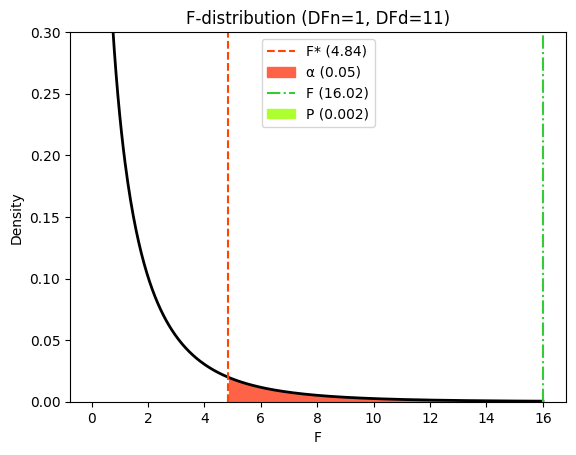

In [276]:
# Significance level (alpha)
α = 0.05

# Calculate critical F-value
f_crit = f(dfn=df_regression, dfd=df_residual).ppf(1 - α)

# Generate x values for plotting
x_f = np.linspace(0, 16, 500)
hx_f = f.pdf(x_f, df_regression, df_residual)

# Create the plot
plt.plot(x_f, hx_f, lw=2, color='black')

# Critical value
plt.axvline(
    x=f_crit,
    color='orangered',
    linestyle='--',
    label=f"F* ({f_crit:.2f})")

# Alpha area
plt.fill_between(
    x_f[x_f >= f_crit],
    hx_f[x_f >= f_crit],
    color='tomato',
    label=f"α ({α})")

# F-statistic
plt.axvline(
    x=f_value,
    color='limegreen',
    linestyle='-.',
    label=f"F ({f_value:.2f})")

# P-value area
plt.fill_between(
    x_f[x_f >= f_value],
    hx_f[x_f >= f_value],
    color='greenyellow',
    label=f"P ({p_value:.3f})")

plt.xlabel("F")
plt.ylabel('Density')
plt.ylim(0, .3)
plt.title(f"F-distribution (DFn={df_regression}, DFd={df_residual})")
plt.margins(x=0.05, y=0)
plt.legend();

In our example, the calculated F-ratio of 16.0 falls far to the right of the critical value, and the shaded area (P value) is very small. This visually confirms the strong evidence against the null hypothesis, supporting the conclusion that the linear regression model provides a significantly better fit to the data than the horizontal line model.

#### ANOVA table

We've now explored the key components of analysis of variance: sums of squares (SST, SSR, SSE), degrees of freedom, and mean squares (MSR, MSE). These elements come together in a structured way within the **ANOVA table**. This table provides a framework for comparing the horizontal line model to the linear regression model and formally testing the significance of the regression.

Here's the ANOVA table for our example comparing the fit of a horizontal line to the best-fit linear regression line:

| Source of variation       | Hypothesis  | Scatter from    | Sum of squares | DF | MS     | F ratio | P value |
|:------------------------- |:----------- |:--------------- |:-------------- |:-- |:------ |:------- |:------- |
| Regression (model) - SSR  | Difference  | Improvement     |      92281     | 1  | 92281  |  16.0   | 0.0021  |
| Error (residual) - SSE    | Alternative | Regression line |      63361     | 11 | 5760.1 |         |         |
| Total - SST               | Null        | Horizontal line |     155642     | 12 |        |         |         |

Interpretation:

- The table partitions the total variation (SST) into the variation explained by the regression model (SSR) and the unexplained variation (SSE).
- The degrees of freedom (DF) are shown for each source of variation.
- The mean squares (MS) are calculated by dividing the sum of squares by the corresponding degrees of freedom.
- The F-ratio, calculated as MSR/MSE, compares the explained and unexplained variation, adjusted for their degrees of freedom.
- The P value helps us determine the statistical significance of the F-ratio.

If the null hypothesis were true (i.e., if there were no relationship between X and y), we would expect the two MS values (MSR and MSE) to be similar, resulting in an F-ratio close to 1.0. However, in our example, the F-ratio is 16.0, suggesting that the regression model explains significantly more variation than would be expected by chance. This small P value (0.0021) provides strong evidence against the null hypothesis.

#### Getting the ANOVA table in Python

In the previous chapter on linear regression, we used the Statsmodels library to fit a linear regression model. Recall that the `summary()` method of the fitted model object provides a table with various statistics, including:

- 'Df Model': degrees of freedom for the regression model.
- 'Df Residuals': degrees of freedom for the residuals.
- 'R-squared': the coefficient of determination.
- 'F-statistic': the F-statistic from the overall model F-test.
- 'Prob (F-statistic)': the P value associated with the F-statistic.

In [277]:
import statsmodels.formula.api as smf
import warnings

# Suppress all UserWarnings, incl. messages related to small sample size
warnings.filterwarnings("ignore", category=UserWarning)

model_linear_reg = smf.ols("insulin_sensitivity ~ per_C2022_fatacids", data=data)
results_linear_reg = model_linear_reg.fit()

# Classical output of the OLS result table
print(results_linear_reg.summary().tables[0])

                             OLS Regression Results                            
Dep. Variable:     insulin_sensitivity   R-squared:                       0.593
Model:                             OLS   Adj. R-squared:                  0.556
Method:                  Least Squares   F-statistic:                     16.02
Date:                 Tue, 03 Dec 2024   Prob (F-statistic):            0.00208
Time:                         18:36:22   Log-Likelihood:                -73.642
No. Observations:                   13   AIC:                             151.3
Df Residuals:                       11   BIC:                             152.4
Df Model:                            1                                         
Covariance Type:             nonrobust                                         


These values correspond directly to the values in the ANOVA table we constructed. Statsmodels also provides [a convenient way to generate a complete ANOVA table using the `anova_lm()` function](https://www.statsmodels.org/stable/generated/statsmodels.stats.anova.anova_lm.html#statsmodels.stats.anova.anova_lm).

In [278]:
from statsmodels.stats.anova import anova_lm

# Print the ANOVA table
print(anova_lm(results_linear_reg, type=3).round(4))

                      df      sum_sq     mean_sq        F  PR(>F)
per_C2022_fatacids   1.0  92280.9337  92280.9337  16.0206  0.0021
Residual            11.0  63361.3740   5760.1249      NaN     NaN


### Nested models

As we've seen, the F-test approach described in this chapter is specifically designed to compare **nested models**, where *one model is a simpler case of the other*. Our linear regression example fits this criterion perfectly: the null hypothesis model (horizontal line) is nested within the linear regression model because it's equivalent to setting the slope of the regression line to zero. This nesting relationship is crucial because it allows us to directly assess the improvement in fit gained by adding the predictor variable (X) to the model. While powerful for comparing nested models, it's important to remember that this particular F-test doesn't apply to situations where we want to compare unrelated models. We'll explore methods for comparing those types of models later in the book.

## Unpaired t-test as a special case of regression

In a previous chapter, we explored the unpaired t-test, a common tool for comparing the means of two independent groups. Now, we'll revisit this familiar test from a fresh perspective, i.e., through the lens of linear regression. Surprisingly, the unpaired t-test can be seen as a special case of linear regression where we use a **binary variable** to represent group membership. This connection not only deepens our understanding of the t-test but also highlights the versatility of linear regression as a framework for statistical analysis.

### Two-group comparison

At its heart, the unpaired t-test is a way to compare two models:

1. The null hypothesis model (horizontal line): this model assumes there's no difference between the means of the two groups. It's represented by a horizontal line at the *overall mean of the combined data*.
2. The alternative hypothesis model (two means): this model allows for a *difference in means between the two groups*. In the context of regression, this is represented by a model with a single dummy variable to distinguish the groups.

When we perform an unpaired t-test, we're essentially asking: *does the model with separate means (represented by the dummy variable) provide a significantly better fit to the data than the model with a single mean (the horizontal line)?*

### Dummy variables

To bridge the gap between the unpaired t-test and linear regression, we need a way to represent group membership within the framework of regression. This is where **dummy variables** come in.

A dummy variable (also called an *indicator variable*) is a binary variable that takes on the value of 0 or 1 to indicate the absence or presence of a categorical effect that may shift the outcome. In the case of the unpaired t-test, we have two groups we want to compare. We can create a dummy variable, often denoted as X, to represent these groups:

- `X = 0`: represents individuals in the first group (e.g., the control group).
- `X = 1`: represents individuals in the second group (e.g., the treatment group).

Remid the simple linear regression equation $y = \text{intercept} + \text{slope} \times X$:
- When `X = 0` (first group), the equation simplifies to $y = \text{intercept}$, this means the intercept represents the *mean of the first group*. Indeed, the intercept of the regression line will be placed in a way that *minimizes* the overall distance between the line and these data points. This position often corresponds to the mean of the first group's y values.
- When `X = 1` (second group), the equation becomes $y = \text{intercept} + \text{slope}$, this means the slope represents the *difference* in means between the second group and the first group.

_Important note: while the intercept often closely approximates the mean of the first group, it might not be exactly equal to the mean. This is because the regression line is fitted using all the data points (from both groups), not just the data points where X = 0. However, the intercept will generally provide a good estimate of the first group's mean._

By incorporating this dummy variable into our regression model, we can model the difference in means between the two groups: 

- If the **slope** of the regression line (associated with the dummy variable) is *statistically significant*, it means that there's strong evidence for a difference in means between the groups, and we would reject the null hypothesis.
- If the slope is not significant, it suggests that the model with a single mean (*horizontal line*) is sufficient, and we fail to reject the null hypothesis.

### Regression analysis of group differences

Let's revisit the data from Frazier and colleagues (2006), where they investigated the impact of norepinephrine on bladder muscle relaxation in rats. We'll focus on their measurements of maximum relaxation (%E<sub>max</sub>) achieved with high doses of norepinephrine, comparing the responses of old and young rats. To represent these groups within a regression framework, we'll assign a dummy variable X as follows:

- `X = 0`: old rats
- `X = 1`: young rats

In [279]:
# Data from the chapter on unpaired t-test
old = np.array([20.8, 2.8, 50, 33.3, 29.4, 38.9, 29.4, 52.6, 14.3])  # Old rats
yng = np.array([45.5, 55, 60.7, 61.5, 61.1, 65.5, 42.9, 37.5])       # Young rats

# Create the DataFrame with the dummy variable 'X'
data = pd.DataFrame({
    'X': [0] * len(old) + [1] * len(yng),  # 0 for old, 1 for young
    'y': np.concatenate([old, yng])        # Combine the data
})

# Print a random sample of the data
data.sample(5)

,X,y
12,1,61.5
9,1,45.5
0,0,20.8
11,1,60.7
1,0,2.8


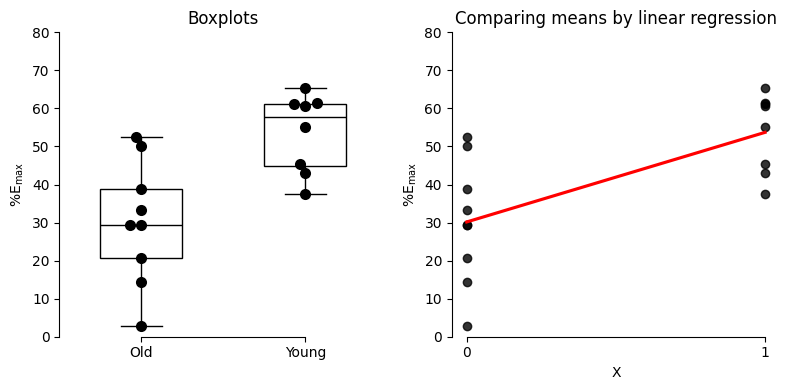

In [ ]:
# Create the figure and axes
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# --- Box and swarm plot ---
sns.boxplot(
    x='X',
    y='y',
    data=data,
    width=0.5,
    color='black',
    ax=axes[0],
    boxprops={'facecolor': 'none'},  # Make the boxplot transparent
)
sns.swarmplot(
    x='X',
    y='y',
    data=data,
    color='black',
    size=8,
    ax=axes[0])
axes[0].set_ylabel(r"$\%\text{E}_\text{max}$")
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Old', 'Young'])
axes[0].set_xlabel("")
axes[0].set_ylim([0, 80])
axes[0].set_title("Boxplots")

# --- Regression plot ---
sns.regplot(
    x='X', y='y', data=data,
    ci=False, color='k',
    ax=axes[1],
    line_kws={'color': 'red'})
axes[1].set_xticks([0, 1])
axes[1].set_ylim([0, 80])
axes[1].set_ylabel(r"$\%\text{E}_\text{max}$")
axes[1].set_title("Comparing means by linear regression")

# --- Adjust layout ---
plt.tight_layout()
sns.despine(trim=True);

#### Performing regression with dummy variables

Now that we've established how our dummy variable (`X`) represents the two groups (old and young rats), let's perform the linear regression analysis. We'll use the same `statsmodels` library we've employed in previous chapters.

In [281]:
# Fit the linear regression model using the formula API
model_ttest = smf.ols('y ~ X', data=data)
results_ttest = model_ttest.fit()

# Print the regression results
print(results_ttest.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.418   
Dependent Variable: y                AIC:                139.1606
Date:               2024-12-03 18:36 BIC:                140.8271
No. Observations:   17               Log-Likelihood:     -67.580 
Df Model:           1                F-statistic:        12.47   
Df Residuals:       15               Prob (F-statistic): 0.00302 
R-squared:          0.454            Scale:              188.28  
------------------------------------------------------------------
                Coef.   Std.Err.    t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept      30.1667    4.5738  6.5955  0.0000  20.4178  39.9155
X              23.5458    6.6674  3.5315  0.0030   9.3346  37.7571
-----------------------------------------------------------------
Omnibus:               0.260        Durbin-Watson:          2.044
Prob(Omnibus):        

The `model.summary2()` output provides a wealth of information. Here are the key elements to focus on in this context:

- Intercept: the intercept estimate represents the **mean** %E<sub>max</sub> for the old rats (where `X = 0`).
- Coefficient for X: this coefficient represents the **difference** in mean %E<sub>max</sub> between the young rats (`X = 1`) and the old rats (`X = 0`). Because our dummy variable X takes on values of 0 and 1, the slope of the best-fit regression line directly equals this difference in means. In our analysis, the slope is 23.55, with a 95% confidence interval ranging from 9.33 to 37.76. This matches the results we obtained from the unpaired t-test. Importantly, the confidence interval of the slope is identical to the confidence interval for the difference between the two means.
- t-statistic and P value for X: these values test the **statistical significance** of the difference in means between the two groups. A small P value (typically less than 0.05) indicates strong evidence against the null hypothesis of no difference. The P value from the linear regression tests the null hypothesis that the slope is zero, which is another way of stating the null hypothesis of the unpaired t-test: that the two populations have the same mean. As expected, the P value determined by linear regression is identical to the P value we obtained from the t-test.

In [282]:
# Descriptive statistics
old_mean = np.mean(old)
yng_mean = np.mean(yng)

print("Mean of the group 'old':", round(old_mean, 6))
print("Mean of the group 'young':", round(yng_mean, 6))
print("Difference in mean:", round(yng_mean - old_mean, 6))

Mean of the group 'old': 30.166667
Mean of the group 'young': 53.7125
Difference in mean: 23.545833


In [283]:
import pingouin as pg

# Student's t-test using Pingouin
pg.ttest(yng, old, correction=False) # type: ignore
# ix=data['X']==0; pg.ttest(data.loc[~ix, 'y'], data.loc[ix, 'y'], correction=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,3.531488,15,two-sided,0.003022,"[9.33, 37.76]",1.715995,12.56,0.909532


Notice that the t-statistic and P value for the `X` coefficient are virtually identical to the results we obtained from a *Student's t-test* assuming equal variances. Now, one of the assumptions of OLS is **homoscedasticity**, which means that the variance of the errors (residuals) is constant across all levels of the predictor variables. So that, when we use a dummy variable to represent two groups, the homoscedasticity assumption implies that the variances of the two groups are equal. Therefore, when we perform a regression with a dummy variable, it *implicitly assumes equal variances* between the groups, leading to a t-statistic that's equivalent to Student's t-test.

#### Goodness of fit and R-squared

R², as we know, represents the proportion of variance in the outcome variable explained by the predictor variable. In this case, our predictor is the dummy variable representing the two groups (old and young rats). Therefore, R² tells us how much of the variability in %E<sub>max</sub> is explained by the difference between the two age groups. A higher R² indicates that a larger proportion of the variability is due to the difference between the groups, suggesting a stronger effect of age on %E<sub>max</sub>.

In [284]:
# Get the predicted values from the Statsmodels model
y_pred = results_ttest.predict()

# Calculate RSS and TSS
sse = compute_sse(y_pred, data['y'])  # RSS using predicted values
sst = compute_sse(np.mean(data['y']), data['y'])  # SST

ssr = sst - sse  # TSS - RSS

# Print RSS, TSS and R²
print(f"Scatter around the regression line (RSS or SSE): {sse:.1f}")
print(f"Scatter around the horizontal line (TSS or SST): {sst:.1f}")
print(f"Variability explained by the regression model (SSR): {ssr:.1f}")
print(f"R²: {1 - sse/sst:.4f}")
print(f"Proportion of variation explained by the regression line (SSR/SST)= {ssr/sst:3.1%}")
print(f"Scatter around the regression line (SSE/SST) accounts for {1 - (ssr/sst):3.1%} of the total variation")

Scatter around the regression line (RSS or SSE): 2824.1
Scatter around the horizontal line (TSS or SST): 5172.2
Variability explained by the regression model (SSR): 2348.1
R²: 0.4540
Proportion of variation explained by the regression line (SSR/SST)= 45.4%
Scatter around the regression line (SSE/SST) accounts for 54.6% of the total variation


It's important to note that R² in this specific scenario might be lower than what we might expect in typical regression analyses. This is because we only have one predictor variable (the dummy variable), and it only has two levels. Therefore, the model might not capture all the variability in the outcome.

While R² provides some information about the effect size, giving us a sense of how much of the overall variation is attributable to the grouping variable, the primary focus in this analysis is usually on the statistical significance of the group difference, as indicated by the t-statistic and P value for the dummy variable's coefficient.

#### ANOVA table for t-test

Just as we did in the previous section, we can construct an ANOVA table to analyze the variance in our regression model with the dummy variable. This table will help us further understand the connection between the F-ratio and the t-statistic in the context of comparing two groups.

The t-test recast as a comparison of models:

| Hypothesis  | Scatter from  | Variation         | Sum of squares | Variation | R²    |
|:----------- |:------------- |:----------------- |:-------------- |:--------- |:----- |
| Null        | Grand mean    | Total (STT)       |      5172      |  100.0%   |       |
| Alternative | Group means   | Unexplained (SSE) |      2824      |   54.6%   |       |
| Difference  | Improvement   | Explained (SSR)   |      2348      |   45.4%   | 0.454 |

Of all the variation (sum of squares from the null hypothesis **grand mean**, represented by SST), 54.6% is caused by scatter **within** each group (**SSE**). It's the variability that remains unexplained even after accounting for the group differences. It represents the inherent variability of the data points within each group around their respective means.

And 45.4% of the total variation is caused by the difference **between** the two **group means (SSR**). It's the variability explained by the difference in means between the groups. A larger "between groups" variation suggests a stronger effect of the grouping factor.

_Note: The distinction between **between-group variation** (variation explained by differences between groups) and **within-group variation** (variation within each group) is crucial not only in the context of t-tests but also in the broader framework of ANOVA. As we'll see in a future chapter, ANOVA extends these concepts to compare the means of three or more groups, allowing us to analyze more complex experimental designs._

Here, SSR represents the reduction in variability achieved by *using separate group means instead of a single grand mean*. In other words, it quantifies how much better we can predict the outcome variable by taking the group membership into account.

In the context of the t-test, SSR reflects the magnitude of the difference between the two group means. A larger SSR indicates a greater difference between the means, suggesting a stronger effect of the grouping variable.

Regarding the **degrees of freedom**, we still have one predictor variable (the dummy variable), so we can calculate the F-statistic and its associated P value as follows. And in linear regression, n represents the total number of data points used to fit the model. This holds true even when we're using a dummy variable to represent groups in a t-test scenario.

In [285]:
n = len(data)  # Number of observations

# Degrees of freedom:
df_regression = 1  # DF for regression (explained variation)
df_residual = n-2  # DF for residuals (unexplained variation) 

f_value = ((sst - sse) / df_regression) / (sse / df_residual) 
print(f"F ratio = {f_value:.4f}")

# Calculate the P-value using the survival function (sf) of the F-distribution
p_value = f(dfn=df_regression, dfd=df_residual).sf(f_value)

print(f"P value = {p_value:.4f}")

F ratio = 12.4714
P value = 0.0030


In our example, with an F-ratio of 12.47 and degrees of freedom of 1 and 15, the P-value is 0.003. This means that if there were truly no relationship between X and y (i.e., if the null hypothesis were true), there would only be a 0.3% chance of observing an F-ratio this large or larger due to random sampling. This small P value provides strong evidence against the null hypothesis, suggesting that the linear regression model, which includes the dummy variable to distinguish between the groups, provides a significantly better fit to the data than the horizontal line model.

Let's visualize these values on F-distribution.

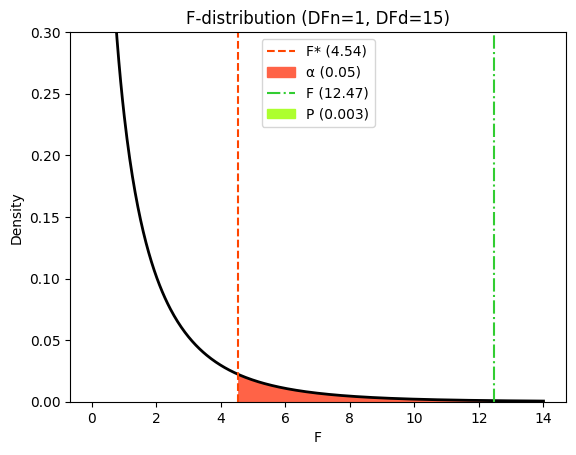

In [286]:
# Significance level (alpha)
α = 0.05

# Calculate critical F-value
f_crit = f(dfn=df_regression, dfd=df_residual).ppf(1 - α)

# Generate x values for plotting
x_f = np.linspace(0, 14, 500)
hx_f = f.pdf(x_f, df_regression, df_residual)

# Create the plot
plt.plot(x_f, hx_f, lw=2, color='black')

# Critical value
plt.axvline(
    x=f_crit,
    color='orangered',
    linestyle='--',
    label=f"F* ({f_crit:.2f})")

# Alpha area
plt.fill_between(
    x_f[x_f >= f_crit],
    hx_f[x_f >= f_crit],
    color='tomato',
    label=f"α ({α})")

# F-statistic
plt.axvline(
    x=f_value,
    color='limegreen',
    linestyle='-.',
    label=f"F ({f_value:.2f})")

# P-value area
plt.fill_between(
    x_f[x_f >= f_value],
    hx_f[x_f >= f_value],
    color='greenyellow',
    label=f"P ({p_value:.3f})")

plt.xlabel("F")
plt.ylabel('Density')
plt.ylim(0, .3)
plt.title(f"F-distribution (DFn={df_regression}, DFd={df_residual})")
plt.margins(x=0.05, y=0)
plt.legend();

Let's put it all together and complete the ANOVA table for our t-test recast as linear regression:

| Source of Variation  | Hypothesis    | Scatter from  | Sum of squares | DF | MS     | F ratio | P value |
|:-------------------- |:------------- |:------------- |:-------------- |:-- |:------ |:------- |:------- |
| Between Groups - SSR | Difference    | Improvement   | 2348           |  1 | 2348.0 | 12.47   | 0.0030  |
| Within Groups - SSE  | Alternative   | Group means   | 2824           | 15 | 188.3  |         |         |
| Total - SST          | Null          | Grand mean    | 5172           | 16 |        |         |         |

Interpreting the ANOVA table:

- Degrees of freedom (DF):
  1. Total: this shows the fit of the null hypothesis model (a single grand mean). With 17 data points and one parameter (the grand mean) $\text{DF} = 16$.
  2. Within groups: this shows the fit of the alternative model (separate group means). With two parameters estimated (the mean of each group) $\text{DF} = 17 - 2 = 15$.
  3. Between groups: this shows the difference between the two models. The alternative model has one more parameter than the null hypothesis model so $\text{DF} = 1$.
- Mean squares (MS):  these variances are calculated by dividing the sum of squares (SS) by the corresponding degrees of freedom (DF).
- F-ratio: if the null hypothesis were true (no difference between group means), we'd expect the mean squares (MS) for "Between Groups" and "Within Groups" to be similar, and their ratio (the F-ratio) would be close to 1.0. In our example, the F-ratio is 12.47, suggesting a difference between the groups.
- P-value: the P value, calculated from the F-distribution, answers this question: If the simpler model (null hypothesis) were true, what's the probability of observing an F-ratio as large as 12.47 or larger due to random chance? In our case, the P value is 0.003, indicating strong evidence against the null hypothesis.

As in the previous example, we can extract the ANOVA table from the corresponding Statsmodels' model results.

In [287]:
# Print the ANOVA table
print(anova_lm(results_ttest, type=3).round(3))

            df    sum_sq   mean_sq       F  PR(>F)
X          1.0  2348.074  2348.074  12.471   0.003
Residual  15.0  2824.149   188.277     NaN     NaN


### F-ratio and t-statistic

In this particular case, where we're using a single dummy variable to compare two groups, there's a direct link between the F-ratio from the ANOVA table and the t-statistic from the regression output:

$$ F = t^2$$

The key connection lies in the fact that the **square of a t-distributed random variable with *k* degrees of freedom follows an F-distribution with 1 and *k* degrees of freedom.** Mathematically, if $T \sim t(k)$, then $T^2 \sim F(1, k)$.

This means the F-ratio is simply the square of the t-statistic. We can verify this by squaring the t-value associated with the `X` coefficient in the `results_ttest` output and comparing it to the F-ratio in the ANOVA table.

In [288]:
# --- Extract the t-value for the dummy variable (X) ---
t_value = results_ttest.tvalues['X']

# --- Print the results ---
print(f"t-value from regression: {t_value:.4f}")
print(f"F-value from ANOVA: {f_value:.4f}")
print(f"t-value squared: {t_value**2:.4f}")

t-value from regression: 3.5315
F-value from ANOVA: 12.4714
t-value squared: 12.4714


This demonstrates the mathematical equivalence between the F-test in the ANOVA and the t-test for comparing two groups. Both approaches are testing the same hypothesis: whether there's a significant difference between the means of the two groups.

By recognizing this connection, we gain a deeper understanding of how these seemingly different statistical tools are fundamentally related, reinforcing the idea that the t-test can be viewed as a comparison between two models: the null hypothesis model (horizontal line) and the alternative model with separate group means (represented by the dummy variable).

### Grand mean model

In the context of comparing two groups using regression, the simplest **baseline** model we can use is the **grand mean model**.

The grand mean model ignores the distinction between groups and estimates a single mean value for the entire dataset. This is equivalent to fitting a horizontal line to the data, where the predicted value for all individuals is simply the *overall mean of the outcome variable*.

In the previous section, we performed the regression with a dummy variable, which allowed us to estimate separate means for the two groups. Now, we want to compare this model to the simpler grand mean model to see if accounting for group membership actually improves our ability to predict the outcome.

In Statsmodels, we can fit the grand mean model using the formula 'y ~ 1' which specifies that we're regressing the outcome variable (y) on a constant term only (represented by 1). This effectively estimates the grand mean of y.

In [289]:
# Fit the grand mean model using the formula API
model_grandmean = smf.ols('y ~ 1', data=data)
results_grandmean = model_grandmean.fit()

# Print the regression results
print(results_grandmean.summary2().tables[1])

               Coef.  Std.Err.         t         P>|t|     [0.025     0.975]
Intercept  41.247059  4.360679  9.458861  5.922799e-08  32.002832  50.491286


While the t-statistic, P value, and confidence interval can be used to test whether the intercept differs significantly from zero, our primary focus here is on the estimated grand mean itself. This value serves as a baseline for comparison when we assess the improvement gained by including the dummy variable and accounting for group differences.

The intercept value of 41.247 represents the estimated grand mean of our outcome variable. This is the average value across all observations, regardless of group membership. The standard error of 4.361 reflects the uncertainty in this estimate.

In [290]:
# Calculate and print the mean
grand_mean = data['y'].mean()
print(f"Mean: {grand_mean:.4f}")

# Calculate and print the standard error of the mean
print(f"SEM: {data['y'].sem():.4f}")

Mean: 41.2471
SEM: 4.3607


To evaluate the importance of incorporating group membership into our analysis, we can compare the grand mean model (`y ~ 1`) with the model that includes the dummy variable (`y ~ X`). This comparison can be formalized using an ANOVA table.

In the context of the grand mean model, remember that:

- **SSR = 0:** the sum of squares regression (SSR) is 0 because there is no predictor variable in the model.
- **SSE = SST:** the sum of squares error (SSE) is equal to the sum of squares total (SST) because there's no explained variance. The model only estimates the grand mean, so all variation is considered unexplained.

Let's construct the ANOVA table with these considerations in mind.

In [291]:
# --- Calculate the Sum of Squares (SS) ---
sst = compute_sse(grand_mean, data['y'])
sse = sst
ssr = 0

# --- Degrees of Freedom (DF) ---
n = len(data['y'])  # Number of observations
df_total = n - 1
df_residual = n - 1  # For the grand mean model, df_residual = df_total
df_regression = 0  # For the grand mean model, df_regression = 0

# Print RSS, TSS and R²
print(f"Scatter around the regression line (RSS or SSE): {sse:.1f}")
print(f"Scatter around the horizontal line (TSS or SST): {sst:.1f}")
print(f"Variability explained by the regression model (SSR): {ssr:.1f}")
print(f"R²: {1 - sse/sst:.4f}")
print(f"Proportion of variation explained by the regression line (SSR/SST)= {ssr/sst:3.1%}")
print(f"Scatter around the regression line (SSE/SST) accounts for {1 - (ssr/sst):3.1%} of the total variation")

Scatter around the regression line (RSS or SSE): 5172.2
Scatter around the horizontal line (TSS or SST): 5172.2
Variability explained by the regression model (SSR): 0.0
R²: 0.0000
Proportion of variation explained by the regression line (SSR/SST)= 0.0%
Scatter around the regression line (SSE/SST) accounts for 100.0% of the total variation


This leads to the following table of the sources of variation:

| Hypothesis  | Scatter from    | Variation         | Sum of squares | Variation | R²    |
|:----------- |:--------------- |:----------------- |:--------------:|:--------- |:----- |
| Null        | Horizontal line | Total (SST)       |      5172      |  100.0%   |       |
| Alternative | Regression line | Unexplained (SSE) |      5172      |  100.0%   |       |
| Difference  | Improvement     | Explained (SSR)   |         0      |     0%    | 0.000 |

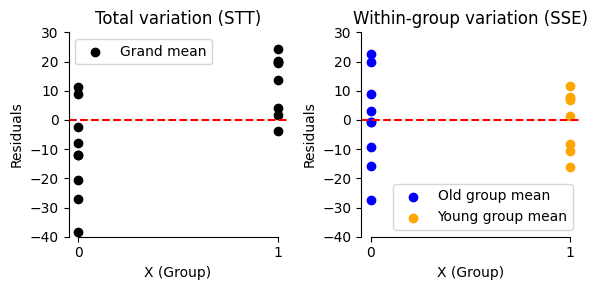

In [326]:
plt.figure(figsize=(6, 3))

# Plot residuals for the grand mean model
plt.subplot(1, 2, 1)
plt.scatter(
    data['X'],
    results_grandmean.resid,
    color='black',
    label='Grand mean')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('X (Group)')
plt.xticks([0, 1])
plt.ylabel('Residuals')
plt.ylim(-40, 30)
plt.title('Total variation (STT)')
plt.legend()

# Plot residuals for the group mean model
plt.subplot(1, 2, 2)
plt.scatter(
    data['X'][data['X'] == 0],
    results_ttest.resid[data['X'] == 0],
    color='blue',
    label='Old group mean')
plt.scatter(
    data['X'][data['X'] == 1],
    results_ttest.resid[data['X'] == 1],
    color='orange',
    label='Young group mean')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('X (Group)')
plt.xticks([0, 1])
plt.ylabel('Residuals')
plt.ylim(-40, 30)
plt.title('Within-group variation (SSE)')
plt.legend(loc='lower right')

plt.tight_layout()
sns.despine(trim=True);

When we have both the grand mean model (`y ~ 1`) and the model with the dummy variable (`y ~ X`), we can directly compare their sum of squared residuals (SSR) to calculate the F-statistic:

1. Calculate SSR for each model:
   - $\text{SSR}_\text{grandmean}$ is the sum of squared residuals for the grand mean model (`y ~ 1`). This represents the total variability in the data when only the grand mean is considered.
   - $\text{SSR}_\text{groupmean}$ is the sum of squared residuals for the model with the dummy variable (`y ~ X`). This represents the unexplained variability when accounting for group membership.
2. Calculate the **difference in SSR**:
    - $\text{SSR}_\text{difference} = \text{SSR}_\text{grandmean} - \text{SSR}_\text{groupmean}$ represents the reduction in variability achieved by including the dummy variable. This is the amount of variability explained by the difference between the groups.
3. Calculate the F-statistic:
   - The F-statistic is calculated as the ratio of the explained variance ($\text{SSR}_\text{difference}$) to the unexplained variance ($\text{SSR}_\text{groupmean}$), each divided by their respective degrees of freedom:

$$
F = \frac{\text{SSR}_\text{difference} / \text{DF}_\text{between}}{\text{SSR}_\text{groupmean} / \text{DF}_\text{within}}
$$

where:
- $\text{DF}_\text{between}$ is the degrees of freedom for the "between groups" variation, which is 1 in this case.
- $\text{DF}_\text{within}$ is the degrees of freedom for the "within groups" variation, which is n minus the number of groups.

A larger F-statistic indicates that the model with the dummy variable explains significantly more variation than the grand mean model, suggesting that group membership is an important factor in explaining the outcome.

In [293]:
# Get the sum of squared residuals (SSR) for each model
ssr_grandmean = results_grandmean.ssr
ssr_groupmean = results_ttest.ssr

# Calculate the difference in SSR
ssr_difference = ssr_grandmean - ssr_groupmean
print(f"SSR grand mean:{ssr_grandmean:.1f}")
print(f"SSR group mean:{ssr_groupmean:.1f}")

# Degrees of freedom
n = len(data)  # Total number of observations
df_between = 1  # DF for Between Groups (number of groups - 1)
df_within = n - 2  # DF for Within Groups (n - number of groups)

# Calculate the F-ratio
f_value = (ssr_difference / df_between) / (ssr_groupmean / df_within)
print(f"F ratio = {f_value:.4f}")

# Calculate the P-value
p_value = f(dfn=df_between, dfd=df_within).sf(f_value)
print(f"P value = {p_value:.4f}")

SSR grand mean:5172.2
SSR group mean:2824.1
F ratio = 12.4714
P value = 0.0030


The [`anova_lm` function performs an analysis of variance to compare one or more fitted linear models](https://www.statsmodels.org/stable/generated/statsmodels.stats.anova.anova_lm.html), therefore, here it is testing whether the inclusion of the dummy variable (i.e., accounting for group membership) significantly improves the model's fit compared to just using the grand mean.

In [294]:
anova_lm(results_grandmean, results_ttest)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,16.0,5172.222353,0.0,NaN,NaN,NaN
1,15.0,2824.148750,1.0,2348.073603,12.471405,0.003022


The reason we're getting the same F and P values is that this ANOVA comparison is mathematically equivalent to the overall F-test performed in the `results_ttest` model itself. Both tests assess the same thing: whether the variance explained by including the dummy variable is significantly greater than the unexplained variance.

In essence, the `anova_lm` function provides a way to explicitly compare the two models, while the overall F-test in `results_ttest` implicitly performs the same comparison as part of its model summary.

## Conclusion

This chapter focused on comparing models within the framework of simple linear regression. We explored how the t-test can be viewed as a special case of regression, and we delved into the ANOVA table as a tool for analyzing variation and comparing model fit.

By understanding the principles of model comparison, we gain a deeper appreciation for the interconnectedness of statistical concepts and develop a more flexible approach to data analysis.

While we focused on comparing nested models, where one model is a simpler version of the other, it's important to be aware that we can also compare unrelated models, such as different types of non-linear models, which we'll explore in future chapters.

Throughout this chapter, we saw how P values arise from comparing the fit of different models. In essence, a P value reflects the probability of observing our data (or more extreme data) if the simpler (null hypothesis) model were true. Model comparison provides a framework for hypothesis testing and helps us choose the best model to represent our data, leading to more informed inferences.

## Cheat sheet

### F-distribution

```python
from scipy.stats import f

# Parameters of the F-distribution
dfn = dfn  # Degrees of freedom of the numerator
dfd = dfd  # Degrees of freedom of the denominator

# Instantiate the F-distribution
f_distribution = f(dfn=dfn, dfd=dfd)

# Calculate mean, variance (and more), median and SD from the distribution
f_distribution.stats(moments='mv')
f_distribution.mean()
f_distribution.median()
f_distribution.std()

# Probability Mass Function - P(X=5)
f_distribution.pmf(k=5)

# Cumulative Distribution Function - P(X<=3)
f_distribution.cdf(x=3)

# Survival Function - P(X>6) or P(X>=7)
f_distribution.sf(x=6)  # Returns the P value

# Percent Point Function
f_distribution.ppf(1 - α))  # Returns the critical F
```

### ANOVA table

```python
import statsmodels.formula.api as smf
model = smf.ols("y ~ X", data=data)
results = model.fit()

from statsmodels.stats.anova import anova_lm
anova_lm(results)
```

## Session information

The output below details all packages and version necessary to reproduce the results in this report.

In [295]:
!python --version
print("-------------")

from importlib.metadata import version

# List of packages we want to check the version
packages = ['numpy', 'pandas', 'matplotlib', 'seaborn', 'scipy', 'pingouin', 'statsmodels']

# Initialize an empty list to store the versions
versions = []

# Loop over the packages
for package in packages:
    try:
        # Get the version of the package
        package_version = version(package)
        # Append the version to the list
        versions.append(package_version)
    except Exception:  # Use a more general exception for broader compatibility
        versions.append('Not installed')

# Print the versions
for package, version in zip(packages, versions):
    print(f'{package}: {version}')

Python 3.12.7
-------------
numpy: 1.26.4
pandas: 2.2.2
matplotlib: 3.9.2
seaborn: 0.13.2
scipy: 1.14.1
pingouin: 0.5.5
statsmodels: 0.14.2
